In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import re

In [64]:
# 크롤링할 사이트 주소 정의
source_url = "https://namu.wiki/RecentChanges"

In [65]:
# 사이트 html 구조에 기반하여 크롤링
req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="table")
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

In [66]:
# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성
page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        if 'png' not in page_url:
            page_urls.append(page_url)

# 중복 url을 제거합니다.
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)

https://namu.wiki/w/%ED%8C%8C%EC%9D%BC:mhyk_%EC%9A%94%EB%A6%AC18.jpg
https://namu.wiki/w/%EB%A6%AC%EB%8D%B8%20%ED%95%98%ED%8A%B8
https://namu.wiki/w/%EC%A0%9C4%EC%B0%A8%20%EA%B5%AD%EA%B0%80%EC%B2%A0%EB%8F%84%EB%A7%9D%20%EA%B5%AC%EC%B6%95%EA%B3%84%ED%9A%8D
https://namu.wiki/w/%EC%99%80%EB%82%98%EB%82%98
https://namu.wiki/w/%ED%8C%8C%EC%9D%B4%EB%84%90%20%ED%8C%90%ED%83%80%EC%A7%80%20%EB%B8%8C%EB%A0%88%EC%9D%B4%EB%B8%8C%20%EC%97%91%EC%8A%A4%EB%B9%84%EC%96%B4%EC%8A%A4/%EC%9D%B4%EA%B3%84


In [67]:
# 데이터 프레임 만들기
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)

In [68]:
for page_url in page_urls:
    # page_url의 html 내용 중 title, category, text 추출
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name='article')
    title = contents_table.find_all('h1')[0]
    category = contents_table.find_all('ul')[0]
    content_paragraphs = contents_table.find_all(name='div')
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출
    # 없을 경우 빈 문자열로 대체
    if title is not None:
        row_title = title.text.replace('\n', ' ')
    else:
        row_title = ' '
    
    # category에도 같은 과정 적용
    if category is not None:
        row_category = category.text.replace('\n', ' ')
    else:
        row_category = ' '
        
    # content_paragraph에도 적용
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace('\n', ' '))
            else:
                content_corpus_list.append('')
    else:
        content_corpus_list.append('')
    
    # 데이터 프레임에 저장
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)
        
df.head()

,title,category,content_text
0,파일:mhyk_요리18.jpg,파일/게임파일/마법사의 약속,0 역링크 토론 편집 역사 ACL 0 역링크 토론 편집 역사 ACL ...
1,리델 하트,영국의 인물창세기전 시리즈/등장인물,1 역링크 토론 편집 역사 ACL 1 역링크 토론 편집 역사 ACL ...
2,제4차 국가철도망 구축계획,국가철도망 구축계획,7 역링크 토론 편집 역사 ACL 7 역링크 토론 편집 역사 ACL ...
3,와나나,와나나,29 역링크 토론 편집 역사 ACL 29 역링크 토론 편집 역사 ACL ...
4,파이널 판타지 브레이브 엑스비어스/이계,파이널 판타지 시리즈,0 역링크 토론 편집 역사 ACL 0 역링크 토론 편집 역사 ACL ...


## 추출: 키워드 정보 추출하기

In [69]:
# 텍스트 데이터 전처리 (한글 이외 문자 전부 제거)
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [70]:
# 각 피처에 모두 적용
df['title'] = df['title'].apply(lambda x:text_cleaning(x))
df['category'] = df['category'].apply(lambda x:text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x:text_cleaning(x))

In [71]:
df.head()

,title,category,content_text
0,파일요리,파일게임파일마법사의 약속,역링크 토론 편집 역사 역링크 토론 편집 역사 분류 파일게임파...
1,리델 하트,영국의 인물창세기전 시리즈등장인물,역링크 토론 편집 역사 역링크 토론 편집 역사 분류 영국의 인...
2,제차 국가철도망 구축계획,국가철도망 구축계획,역링크 토론 편집 역사 역링크 토론 편집 역사 분류 국가철도망...
3,와나나,와나나,역링크 토론 편집 역사 역링크 토론 편집 역사 분류 와나나 ...
4,파이널 판타지 브레이브 엑스비어스이계,파이널 판타지 시리즈,역링크 토론 편집 역사 역링크 토론 편집 역사 분류 파이널 판...


In [72]:
# 키워드 추출을 위해서는 명사, 혹은 형태소 단위의 문자열을 추출해야함 - 말뭉치 생성
# 제목, 카테고리, 본문 말뭉치 총 3개의 말뭉치를 생성

In [73]:
# 각 피처마다 말뭉치 생성
title_corpus = ''.join(df['title'].tolist())
category_corpus = ''.join(df['category'].tolist())
content_corpus = ''.join(df['content_text'].tolist())

In [74]:
# 한국어 형태소 추출을 위해 konlpy를 사용

In [75]:
from konlpy.tag import Okt
from collections import Counter

In [76]:
# konlpy 형태소 분석기로 명사 단위의 키워드를 추출
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [77]:
# 한 글자 키워드 제거 (예외처리를 해야 할 경우도 있지만 여기서는 일단 제거)
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'문단': 13656, '문서': 11882, '이전': 11350, '역사': 11125, '토론': 6046, '편집': 5702, '때문': 5637, '사항': 5611, '합의': 5587, '공격': 4252, '자신': 4181, '경우': 4175, '이후': 3931, '한국': 3922, '정도': 3665, '사건': 3369, '대한': 3363, '사람': 3354, '유닛': 3340, '다른': 3264, '부분': 3156, '사용': 3145, '원시': 2992, '사실': 2851, '내용': 2650, '시간': 2621, '게임': 2583, '나폴레옹': 2550, '국가': 2515, '레벨': 2487, '시작': 2454, '관계': 2424, '위해': 2405, '모습': 2388, '하카': 2387, '당시': 2372, '하나': 2366, '피해': 2285, '능력': 2231, '해당': 2212, '방송': 2196, '민주당': 2179, '문제': 2177, '생각': 2138, '가장': 2087, '관련': 2070, '또한': 2021, '쿠키': 1946, '논란': 1943, '모든': 1939, '독일': 1914, '이름': 1897, '정부': 1855, '실제': 1734, '이상': 1730, '페미니즘': 1709, '현재': 1706, '대상': 1703, '본인': 1694, '미국': 1678, '상태': 1651, '보스': 1638, '매우': 1636, '스킬': 1632, '모두': 1609, '상황': 1600, '여성': 1562, '등장': 1546, '대해': 1545, '존재': 1538, '다시': 1538, '주의': 1536, '김정일': 1533, '국민': 1526, '음악': 1517, '후보': 1511, '다만': 1493, '활동': 1489, '플레이어': 1489, '영상': 1411, '가지': 1408, '역시': 1

In [78]:
# 불용어 사전을 통한 키워드 정제
korean_stopwords_path = 'data/korean_stopwords.txt'

In [79]:
# 불용어 텍스트 파일 오픈
with open(korean_stopwords_path, encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [80]:
# 나무위키에 필요한 불용어 추가
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월', '문단', '이전']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

In [81]:
# 위에서 1단어 삭제 이후 처리된 걸 확인
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'역사': 11125, '토론': 6046, '사항': 5611, '합의': 5587, '공격': 4252, '한국': 3922, '사건': 3369, '대한': 3363, '사람': 3354, '유닛': 3340, '부분': 3156, '원시': 2992, '게임': 2583, '나폴레옹': 2550, '국가': 2515, '레벨': 2487, '시작': 2454, '관계': 2424, '위해': 2405, '하카': 2387, '당시': 2372, '피해': 2285, '능력': 2231, '방송': 2196, '민주당': 2179, '문제': 2177, '관련': 2070, '쿠키': 1946, '논란': 1943, '독일': 1914, '정부': 1855, '실제': 1734, '페미니즘': 1709, '현재': 1706, '대상': 1703, '본인': 1694, '미국': 1678, '상태': 1651, '보스': 1638, '스킬': 1632, '여성': 1562, '등장': 1546, '대해': 1545, '존재': 1538, '다시': 1538, '주의': 1536, '김정일': 1533, '국민': 1526, '음악': 1517, '후보': 1511, '활동': 1489, '플레이어': 1489, '영상': 1411, '가지': 1408, '역시': 1408, '이유': 1407, '체력': 1383, '일부': 1378, '방어': 1372, '자체': 1371, '진화': 1367, '해설': 1357, '이야기': 1346, '참고': 1342, '전투': 1305, '멤버': 1288, '속도': 1283, '영화': 1282, '증가': 1280, '일본': 1246, '통해': 1245, '전쟁': 1236, '사이트': 1232, '대표': 1227, '러시아': 1227, '이미지': 1225, '고등학교': 1209, '교단': 1204, '흑인': 1196, '노래': 1195, '기본': 1194, '세계'

## 시각화: 워드 클라우드 시각화하기

In [82]:
# 키워드 빈도 분석에 가장 적합한 시각화 방식 : 워드 클라우드 (pytagcloud)
# 키워드 정보 객체로부터 가장 빈도수가 높은 n 개의 키워드를 추출
# 빈도수를 40개로 설정하고 디자인 관련 파라미터인 maxsize는 80

In [83]:
import random
import pytagcloud
import webbrowser

In [84]:
# 가장 빈도가 높은 40개 단어 선정
ranked_tag = remove_char_counter.most_common(40)

In [91]:
taglist = pytagcloud.make_tags(ranked_tag, maxsize=120)

In [92]:
# pytagcloud 이미지 생성
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900,600),
                           fontname='NanumGothic', rectangular=False)

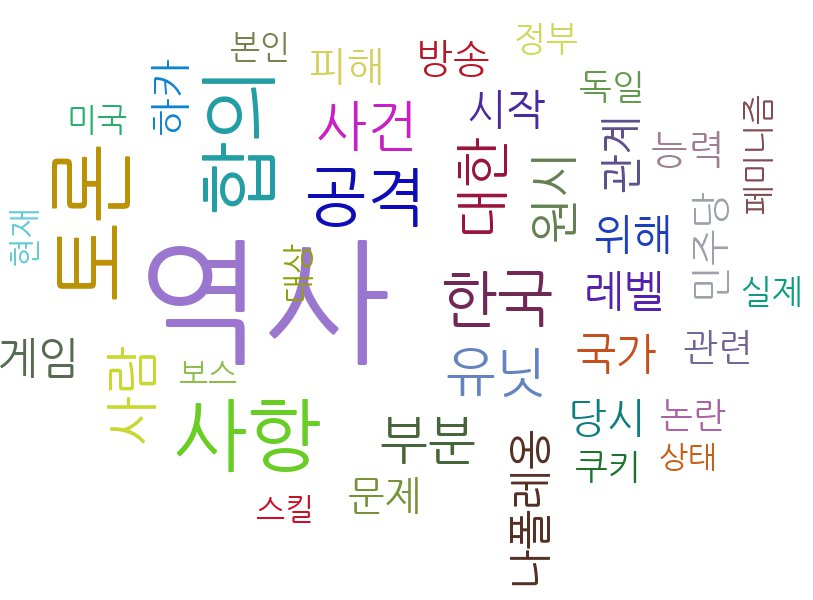

In [93]:
from IPython.display import Image
Image(filename='wordcloud.jpg')